# Real-time anomaly detection using Timeseries Insights API 

### Summary

This notebooks demostrate how to use Google Cloud's [Timeseries Insights API](https://cloud.google.com/timeseries-insights) for real time anomaly detection in time series data. This tutorial covers API dataset creation, querying for anomaly, append new data and deletion of unwanted API datasets. 

### Prerequisites

- Timeseries dataset wth attributes that you want to detect anomaly on

### Objectives

 - Setup resources
 - Create dataset and json format file 
 - Create and list all API dataset using json file in cloud storage bucket
 - Querying for anomaly in an API dataset & evaluating slice
 - Append new data stream to an existing dataset
 - Consume the results for further analysis
 - Deleteting unwanted API dataset
 - Optional: Cloud function code

#### Setup resources

In [ ]:
# Install dependencises

import json
import requests
import datetime
from datetime import date
import time
from oauth2client.client import GoogleCredentials
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import storage
import pandas as pd
import pandas_bokeh
import pandas_gbq

In [ ]:
# Setup variables 

project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = "us-central1"
BQ_DATASET_NAME = "<YOUR-BQ-DATASET-NAME>"
BQ_SOURCE_TABLE_NAME = "<YOUR-RAW-SOURCE-TABLE-NAME>"
BQ_INTMED_TABLE_NAME = "<YOUR-INTERMEDIATE-BQ-TABLE-NAME>"
BQ_FINAL_TABLE_NAME = "<YOUR-FINAL-BQ-TABLE-NAME>"
BUCKET_NAME = "<YOUR-BUCKET-NAME>"
FILE_PATH = "<local-path-to-your-processed-file>/timeseries-anomaly.json"

print(PROJECT_ID, REGION, BUCKET_NAME)

In [ ]:
# Setup client

bq_client = bigquery.Client()

#### Create dataset and json format file 

Timeseries Insights API is a large scale, low latency forecasting and anomaly detection API that provides results in real time and with timeseries with billions of events. It is managed, secure and easy to use and setup. A typical time series contains time or timestamp column with other attributes. Timeseries Insights API allows easy way to slice these events in timeseries to query for anomalies. Before we can query for anomaly using the API, dataset must be converted into newline delimited json format for API to consume and create dataset. You can refer to [this](https://cloud.google.com/timeseries-insights/docs/tutorial) guide to build the appropriate dataset format for API. Additionaly you can also refer to [this](https://cloud.google.com/timeseries-insights/docs/query-building-guide) query building guide to learn how to form query payload. 

Here is the tabular form of the data

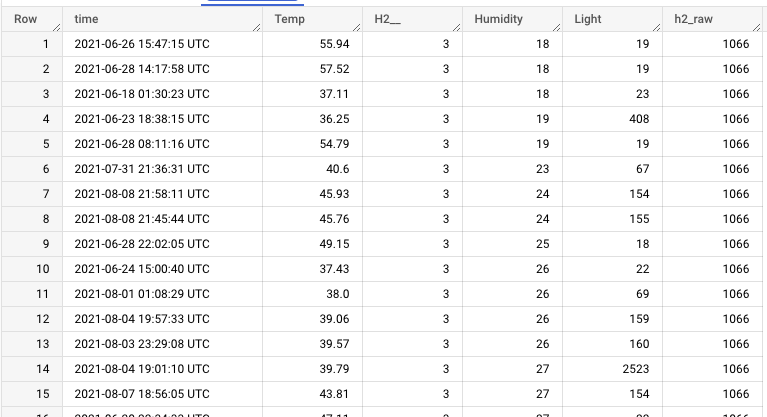

In the query below, BigQuery's `FARM_FINGERPRINT` hash function is used to generate groupId for each event in our data. Next we save this into a new BigQuery table 

In [ ]:
sql = f"""
 SELECT 
  farm_fingerprint(concat(cast(timestamp as string), cast(h2 as string), cast(temperature as string), cast(humidity as string), cast(light as string))) as groupId,
  timestamp_seconds(cast(timestamp as int64)) as eventTime,
  h2__ as h2, 
  temperature,
  humidity,
  light,
 FROM `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_SOURCE_TABLE_NAME}` order by 2 
"""

df = bq_client.query(sql).to_dataframe()
df = df.sort_values("eventTime", ascending=True)
df.head()

Before we do data preprocessing, let's plot this data

In [ ]:
# data frame with normalized values for temperature and light

normFrame = df.copy(deep = True)
cols_to_norm = ['temperature','light', 'humidity', 'h2']
normFrame[cols_to_norm] = normFrame[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [ ]:
pandas_bokeh.output_notebook()

In [ ]:
startTime = pd.to_datetime("06/14/21", infer_datetime_format=True) 
endTime =  pd.to_datetime("08/09/21", infer_datetime_format=True) 

size = (1400,500)
normFrame.plot_bokeh(x = 'eventTime' , 
               xlabel = 'time',
               y = ['temperature','light', 'humidity', 'h2'], 
               kind = 'line', 
               figsize = size,
               xlim = [startTime, endTime],
               title="both (normalized)"
              )

pandas_bokeh.output_file("chart_light.html")
df.plot_bokeh(x = 'eventTime' , 
               xlabel = 'time',
               y = ["light"], 
               kind = 'line', 
               figsize = size,
               xlim = [startTime, endTime],
               title="light"
              )

From this chart, we can clearly see that there is a period of window (between 06/24/21 - 06/28/21) where temperature values increased rapidly and appears to be an anomaly. We will use this period to query for anomaly in the later section of this notebook. but before we can use this data within API, this data needs to be converted into a desired format that API can accept, first we use pandas dataframe melt method to keep one columns for all attribute values.

In [ ]:
# melt the dataframe
df = df.melt(id_vars=['groupId','eventTime'])

In [ ]:
table_id=f"{BQ_DATASET_NAME}.{BQ_INTMED_TABLE_NAME}"
pandas_gbq.to_gbq(df,table_id,project_id=PROJECT_ID)

We now convert datatype for values from `string` to `float` and save result in another BQ table

In [ ]:
#convert value column to float and save result in a bq table
sql_conv = f"""
select   
  groupId,
  eventTime,
  variable,
  cast(value as float64) as value
from `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_INTMED_TABLE_NAME}` order by 2
"""
df_conv = client.query(sql_conv).to_dataframe()
df_conv.head()

table_id=f"{BQ_DATASET_NAME}.{BQ_FINAL_TABLE_NAME}"
pandas_gbq.to_gbq(df_conv,table_id,project_id=PROJECT_ID)

Now, we will use data from this table to convert dimensions as orderable datatype for each gropupId and eventTime using `STRUCT`

In [ ]:
# Read melted data from BQ table and prepare json for time series indight API dataset

sql_out = f"""
with data as
    (
        select groupId, eventTime, STRUCT(variable as name, value as doubleVal) as dimensions 
        from (
                select * from `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQ_FINAL_TABLE_NAME}`
                order by eventTime, variable
             )
    )

    SELECT cast(eventTime as string) eventTime, cast(groupId as string) as groupId, ARRAY_AGG(dimensions) AS dimensions FROM data GROUP BY eventTime, groupId order by eventTime
"""
df_out = client.query(sql_out).to_dataframe()
df_out.head()

In [ ]:
# write data to json
df_out.to_json("/path-to-file/processed.json", orient="records", lines=True)

Lastly, will use some linux command to add measure dimension into dimensions attribute. Note that we could not do this using SQL because measure has datatype of `string` while all other dimensions are of type `float` therefore it is not possible to use struct for both in same sql statement

In [ ]:
# use sed to replace text in processed file --> #DO NOT RUN

! sed -i '' 's/{"name":"h2",/{"name":"measure","stringVal":"LTTH"},{"name":"h2",/g' /path-to-output-file/timeseries-anomaly.json

and after the all the transformation, here is how our data looks like

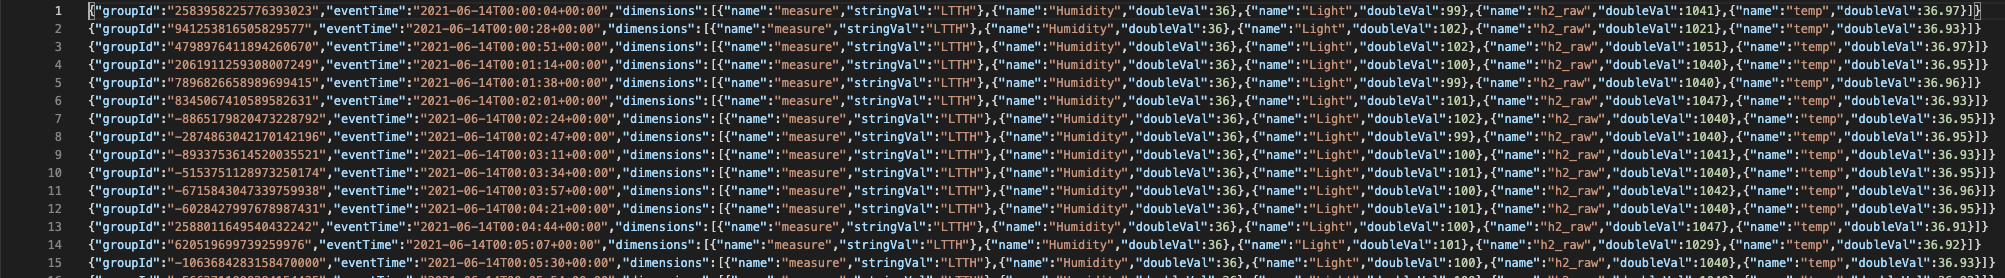

This newline delimited json file will be saved in the cloud storage bucket which API can refer to create dataset in next steps. 

In [ ]:
# Create bucket and upload the processed data file

! gsutil mb -l $REGION -c standard gs://$BUCKET_NAME

! gcloud alpha storage cp $FILE_PATH gs://$BUCKET_NAME/

#### Allowlist the API

Since the API is in public preview at the moment, you'll need to allowlist Google cloud project you are working on. Once the API is GA, you don't need to perform this step and can skip it. 

Click [here](https://services.google.com/fb/forms/timeseries-insights-api-preview-registration/) to allowlist your Google cloud project. You won't be able to access the api till this step is completed. 

#### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already authenticated. Skip this step.

In the Cloud Console, go to the [Create service account key](https://console.cloud.google.com/apis/credentials/serviceaccountkey) page.

1. **Click Create service account**.

2. In the **Service account name** field, enter a name, and click **Create**.

3. In the **Grant this service account access to project** section, click the Role drop-down list. Select "Other" form the list, and scroll down and select **Timeseries Insights DataSet Owner**.

4. Click Create. A JSON file that contains your key downloads to your local environment.

In [ ]:
# Helper functions 

def query_ts(method, endpoint, data, auth_token):
    data = str(data)
    headers = {'Content-type': 'application/json', "Authorization": f"Bearer {auth_token}"}
    
    if method == "GET":
        resp = requests.get(endpoint, headers=headers)
    if method == "POST":
        resp = requests.post(endpoint, data=data, headers=headers)
    if method == "DELETE":
        resp = requests.delete(endpoint, headers=headers)

    return(resp.json())

In [ ]:
# authorize the service account

!gcloud auth activate-service-account --key-file {key_file}
token_array = !gcloud auth print-access-token 
token_array

#### Create and list API dataset

The first step in anomaly detection is to create dataset using the json data file from cloud storage bucket. The data file needs to be in the cloud storage bucket as during the dataset creation payload, it requires path to the file. Once you call the dataset create API method, tt can take a while to create a dataset depending on the dataset size. 

A list dataset method can be called to check the status of all datasets for Timeseries Insights API. All the datasets that have been loaded correctly will have status as `LOADED` and the ones that are currently being indexes will have status as `LOADING`. Note that a dataset can be queries for anomaly only after indexing is done and the dataset status changes to `LOADED`

In [ ]:
dataset = "sensor-data"

In [ ]:
# Create dataset using API

anomaly_dataset_payload = {
    "name": dataset, 
    "ttl": "3000000s", # Set this only if using appending later. This tells API what records to discard. 
    "dataNames": [
        "measure",
        "Humidity",
        "Light",
        "h2_raw",
        "temp",
    ],
    "dataSources": [
        {"uri": f"gs://{BUCKET_NAME}/timeseries-anomaly.json"} 
    ], 
} 

The above json objet is what is used to create the dataset in the Timeseries Insights API. The `name` attribute is just the name of API dataset. You can set any descriptive name you wish for it. `ttl` attribute stands for time to live (in seconds) which can be used to discard events when new data is being appended. This tells the API which older records to discard when creating the timeseries. The records with timestamp older than ttl values is discarded. Here ttl value is set to 3 million seconds which is roughly 35 days.

Next `dataNames` attribute contains all the dimensions from your dataset that you want to index. Note that you can index all or subset of dimensions from your dataset. You can only query for anomalies using the dimensions that are indexed. In this case, all the dimensions from dataset have been used. Lastly, `dataSources` attribute contains the cloud storage bucket uri of json file that contains all your data.

**Note: Once dataset has been created and indexes from given file, that file is no longer necessary for API to funtion. Adding new data to the file won't automatically create indexes on new data. You can only index new data using append method.**

In [ ]:
res = query_ts(method="POST", endpoint=ts_endpoint, data=anomaly_dataset_payload, auth_token=token_array[0])
res

#### List dataset

After running above command to create dataset, you can check the status using following commands

In [ ]:
listdata = query_ts(method="GET", endpoint=ts_endpoint, data="", auth_token=token_array[0])
listdata

#### Querying for anomaly

Once the dataset has been created successfully with status as `LOADED`, we are ready to query for anomaly. Like create dataset payload, we need to create another payload with parameter to query for anomaly in our dataset. You can refer to [this](https://cloud.google.com/timeseries-insights/docs/tutorial#query_dataset) guide to explore all available options and parameter to design anomaly query. Also [here](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.locations.datasets/query) is the query method for API that explains all the available options to include in a query. 

For this tutorial, we are going to use `temp` as dimension to query anomalies on. 

**Note:** The timeseries Insights API only allws one dimensions at a time to query for anomaly i.e. if your dataset has multiple variates and you'd like to query for anonmalies on more than one variates then you'd have to create and issue a separate query payload with desired variates as metric. 

As you can see in the plot above, the values of light fluctuated a lot and values for light and temperature were more or less consistent except some days where there was a sharp increase in temperature values and sharp decline in hydrogen values around the same time. For analysis in this article, I am going to consider only temperature values and we will try to detect the anomalies in the temperature values. 

If you look closely to only temperature values, it spiked very quickly between 06/21/21 to 06/28/21. For this tutorial, this timeframe will be used to query to check anomalies in temperature values

In [ ]:
# Query for anomaly

anomaly_query_payload = {
    "detectionTime": "2021-06-27T15:00:00Z", #Input the date of a timestamp that was appneded to your dataset. We will query the timestamp at point event[90]
    "slicingParams": {
        "dimensionNames": ["measure"]
        },
    "timeseriesParams": {
        "forecastHistory": "259200s",
        "granularity": "1800s",
        "metric": "temp",
       
        },
    "forecastParams": {
        "noiseThreshold": 50.0,
        "seasonalityHint": "DAILY"
        },
    "returnTimeseries": "true"
}

# get forecast
query_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}:query'
res = query_ts(method="POST", endpoint=query_ds_endpt, data=anomaly_query_payload, auth_token=token_array[0])
res

The above payload is asking the API for anomaly art the timestamp mentioned in the `detectionTime`. `timeseriesParams` refers to set of parameters to set the historical data to consider for forecasting, set the `granualarity` (used for aggregation), and `metric` which is the dimension we are querying anomaly for. 

`forecastParams` are the set of parameter to tune for sensitivity. A higher `sensitive` value (ranges between 0 to 1) of results in high number of anomalies for a given slice and vice-versa. If the data contains seasonal patterns, it can be set using `seasonalityHint` parameter. 

Essentially in the above query, we are asking for anomaly in temparature value at the timestamp `2021-06-26T15:00:00Z` with daily seasonality. Also if you look at the timeseriesParams we have used granularity as 360 seconds. Timeseries Insights API used this to formulate timeseries behind the scene where all events attribute values will be aggregated for time period using this granualarity value. You can use sum or avg for aggregation methos and by default sum is used. You can inspect this timeseries using [`evauateSlice`](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.locations.datasets/evaluateSlice) method as well. 


Below is how a raw events timeseries is transformed to a new timeseries form where attribute values have been aggregated by time period 360 seconds. For the illustration purpose, it shows all the attributes but in reality time series will only contains the dimension used in `metric` field in the query payload. 

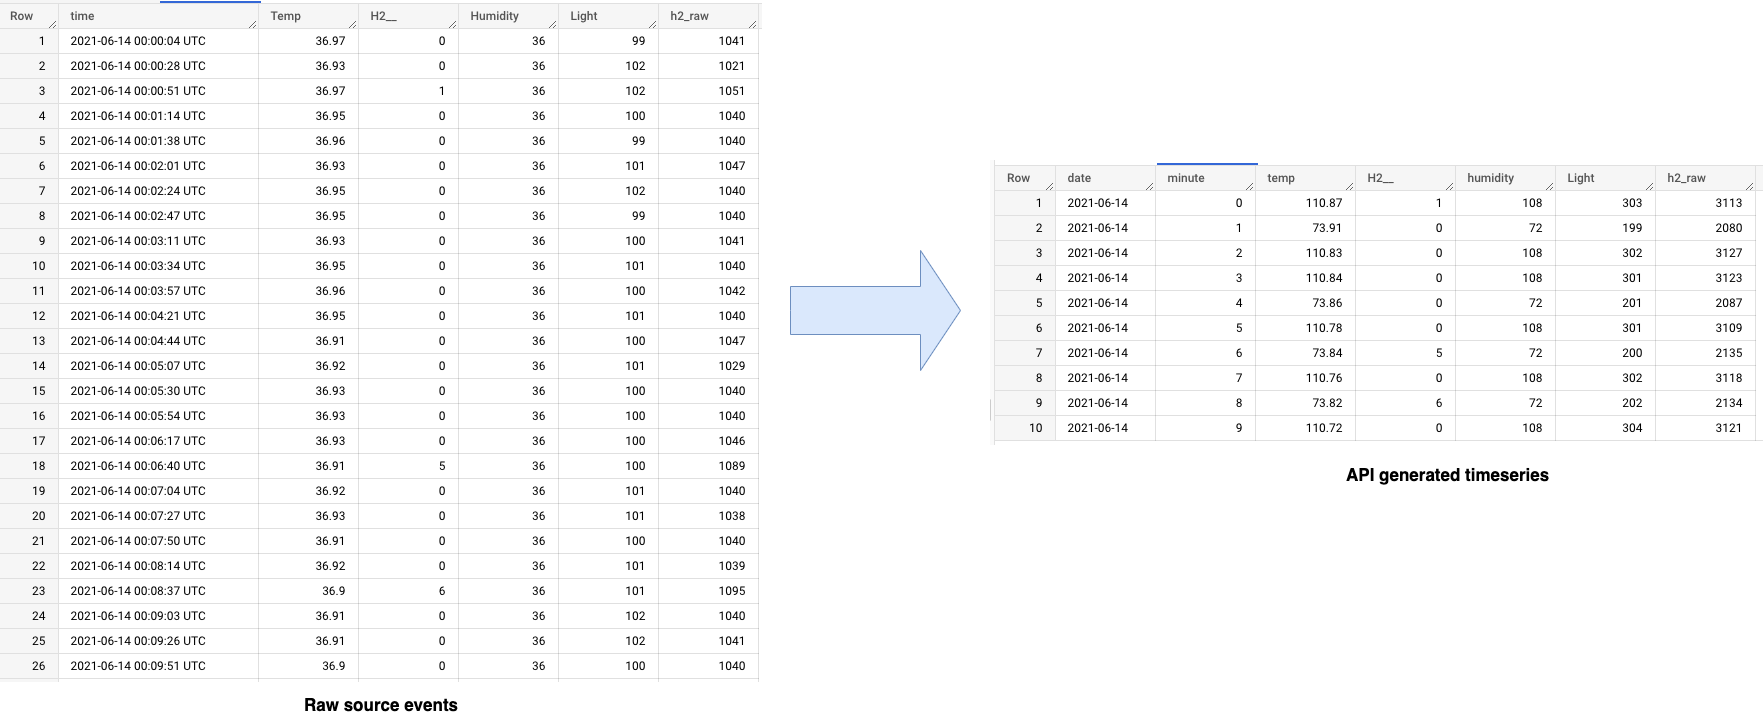

Now let's discuss how to interpret the query result. For each query, there are few things in the result. 

 - **detectionPointActual** this is the value of timeseries attrbitue that you queried for (metric = temperature in this case). This is the actualy value (aggregated) at the `detectionTime`. 
 - **detectionPointForecast**  is the forecasted value at the `detectionTime` for timeseries attribute.
 - **expectedDeviation** indicated the confidence level in the forecasting values. It specifies the absolute deviation from the forecsted value by the API. 
 - **anomalyScore** you can think of this as actual deviation between forecasted value and actual value at `detetionTime`. If this value is higher then we consider a slice to be an anomaly. In other word, this score indicates how far actual deviation is from expected deviation. 
 
<br>
 
$$ anomalyScore = {(detectionPointActual - detectionPointForecast) \over  expectedDeviation } $$

<br>
In general, scores lower than 1.0 reflect variations that are common considering the history of the slice, while scores higher than 1.0 should require attention, with higher scores representing more severe anomalies.

This result can be consumed in downstream application for business purpose. 

#### Append new data stream to an existing dataset

One of the great feature of the Timeseries Insights API is ability to add data in streaming fashion to an existing API database and have it indexed in real time to query for anomaly. This is a very common IoT use case where data stream could come from let's say various IoT devices such as sensor readings and users needs to perform anomaly detection on this new data. 

The steps for appending new events are as follows:

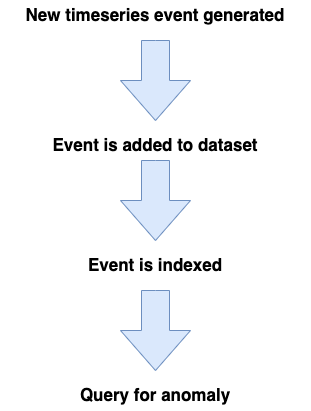

While appending new events in Timeseries Insights API are easy, there are few caviates that you need to be aware of:
    
1. You cannot add events too far in the past using [appendEvents](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.datasets/appendEvents) method. The `appendEvents` method is not to be used for backfilling the data in the timeseries and therefore the timestamp of the events being appended needs to be around current datetime. The way to determine on how far you can go back in history for appending the data is using following calculation. 

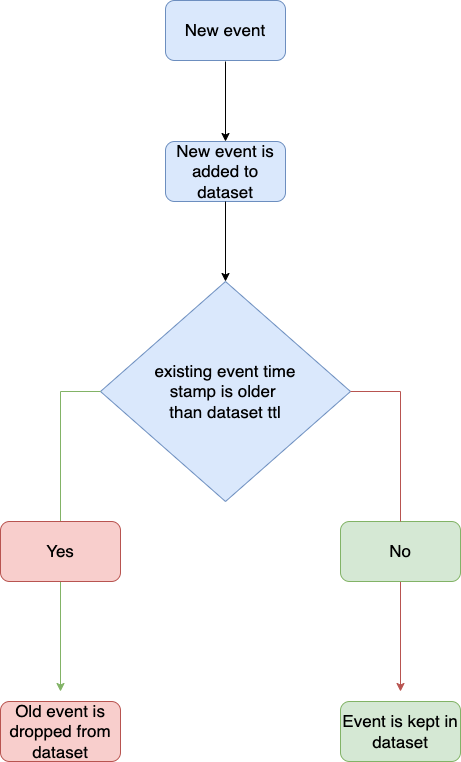

2. When you append an event in an existing dataset, you can only see that event using `evaluateSlice` method. The number of rows using list dataset does not reflect new number of rows in dataset which can be confusing for user if one is looking for total number of rows in a dataset using list method. 

To append a new event in the Timeseries Insights API, we need payload with all the dimension (similar to what we did for data creation) and call API's [appendEvents](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/projects.datasets/appendEvents) method. 

In [ ]:
new_event_payload = {
               {
              "events": [
                {
                  "groupId":"1324354349507023708",
                 "dimensions":[
                                 {"name":"measure","stringVal":"LTTH"},
                                 {"name":"Humidity","doubleVal":36},
                                 {"name":"Light","doubleVal":99},
                                 {"name":"h2_raw","doubleVal":1041},
                                 {"name":"temp","doubleVal":36.97}
                             ],
                  "eventTime":"2021-08-09T21:31:54+00:00"
                }
                      ]
                }
            }


# append event call
query_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}:appendEvents'
res = query_ts(method="POST", endpoint=query_ds_endpt, data=new_event_payload, auth_token=token_array[0])
res

**IMPORTANT:** It is important to note here that appending new events in an existing Timeseries Insights API dataset does not allow direct access to this event i.e. if you wish to perform additional analysis on this data, you need to keep raw events into a separate table along with appending in API dataset. For example, if your historical data that is used to create the API dataset lives in a BigQuery table, then you can use Bigquery streaming insert API or storage write API depending on the use case to write this incoming event in that BigQuery table.

Once the event has been added `evaluateSlice` method can be used to evaluate data slice in a loaded dataset. This is an option you can use to view the timeseries built by the API. 

Following is the sample json payload illustrating an event that we want to evaluate. The returned object after calling the [evaluateSlice](https://cloud.google.com/timeseries-insights/docs/reference/rest/v1/EvaluatedSlice) method is an instance of EvaluatedSlice

In [ ]:
evaluate_slice_payload = {
    "detectionTime": "2021-08-09T21:31:54+00:00",
      "pinnedDimensions": [
        {
          "name": "measure",
          "stringVal": "LTTH"
        }
  ],
    "timeseriesParams": {
        "forecastHistory": "259200s",
        "granularity": "1800s",
        "metric": "temp"
        },
    "forecastParams": {
        "seasonalityHint": "DAILY"
        },
}

dataset = "sensor-data"
query_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}:evaluateSlice'
res = query_ts(method="POST", endpoint=query_ds_endpt, data=evaluate_slice_payload, auth_token=token_array[0])
res

#### Consume the results for further analysis

When we append new events in an existing dataset in Timeseries Insights API, this event gets added to datase that exists within API and **not to the raw timeseries** that you may have used to create the dataset initially i.e. once you add the events in API dataset, you loose the access to that event for any further analysis. Therefore its always a **good practice** to save this new event in a raw timeseries for example a BigQuery table and append in the API dataset. There are couple optoions you can choose from depending on the business requirement. These include options such as Bigquery streaming insert API or storage write API. 

Once this new event is added to the raw timeseries table, it can be queries or used in dashboard to vislualize the anomalies for end business users. 

#### Deleteting  API dataset

Deleting an unwanted dataset in the Timeseris Insights API is very easy. Each of the dataset is created and has indexed is being charged and it becomes easy to create many datasets for testing purpose so at some time we need to deelte those unwanted and unused dataset from the API. The API has `delete` method to delete the datasets. 

In [ ]:
# delete datasets

delete_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset}'
res = query_ts(method="DELETE", endpoint=delete_ds_endpt, data=None, auth_token=token_array[0])
res

#### Optional: End-to-end Implementation 

In order to call the `Timeseries Insights API`, we could wrap all the above steps in a cloud function that can be triggered using a pub/sub topic. User can publish the incoming new events to the pub/sub topic and cloud function will ingest that data into an existing API dataset, make call for anomaly, saves the anomaly result in the raw table for further analysis. Since cloud function is not the topic of focus for this notebook, I am not going to cover that in more details but providing sample code that you can use to create a cloud function in your Google Cloud project. 

For more details on how to create, checkout following resources:

- [Creating cloud function in Google cloud](https://cloud.google.com/functions/docs/create-deploy-gcloud)
- [Creating pub/sub topic](https://cloud.google.com/pubsub/docs/admin#pubsub_create_topic-python)
- [Publish message on a pub/sub topic](https://cloud.google.com/pubsub/docs/publisher)
- [Publish message on pub/sub quickstart](https://cloud.google.com/pubsub/docs/publish-receive-messages-client-library)

In [ ]:
%%writefile prebuilt-apis/requirement.txt

#libraries required for cloud function
# package>=version
google-auth
requests==2.24.0
numpy==1.22.3
oauth2client
google-cloud-bigquery==3.3.1

In [ ]:
%%writefile prebuilt-apis/main.py

import base64
import google.oauth2.id_token
import google.auth.transport.requests
import json
import os
import csv
import requests
import datetime
from datetime import date
import time
from oauth2client.client import GoogleCredentials
from google.auth.transport.requests import AuthorizedSession
from google.oauth2 import service_account
from google.cloud import bigquery


def detect_anomaly(event, context):
    """Triggered from a message on a Cloud Pub/Sub topic.
    Args:
         event (dict): Event payload.
         context (google.cloud.functions.Context): Metadata for the event.
    """
    
    #read incoming message from pubsub
    pubsub_message = base64.b64decode(event['data']).decode('utf-8')
    
    #date reformatting
    date = int(pubsub_message["attributes"]["time"])
    date = datetime.datetime.fromtimestamp(date).strftime('%Y-%m-%d %H:%M:%S')
    final_time = date.replace(" ","T") + "Z" 

    event_decoded = pubsub_message["attributes"]

    #Build out JSON Payload for append
    eventdict = {}

    #extract event attributes
    time = int(event_decoded["time"])
    h2 = str(event_decoded["h2"])
    temperature = str(event_decoded["temperature"])
    humidity = str(event_decoded["humidity"])
    light = str(event_decoded["light"])

    request_json["attributes"]["time"] = final_time

    #create groupid for appending event
    cols = (time, h2, humidity, light, temperature)
    groupid =  hash(cols)

    eventdict["groupId"] = float(groupid)
    eventdict["eventTime"] = event_decoded["time"]
    dimensions = [
        {"name": "measure", "stringVal": "LTTH"},
        {"name": "humidity", "doubleVal": float(event_decoded["humidity"])},
        {"name": "light", "doubleVal": float(event_decoded["light"])},
        {"name": "h2", "doubleVal": float(event_decoded["h2"])},
        {"name": "temperature", "doubleVal": float(event_decoded["temperature"])}
    ]
    eventdict["dimensions"] = dimensions
    eventdict["dataset"] = event_decoded["dataset"]
    eventdict["metric"] = event_decoded["metric"]
    eventdict["forecast_history"] = event_decoded["forecast_history"]
    eventdict["granularity"] = event_decoded["granularity"]
    eventdict["noise_threshold"] = event_decoded["noise_threshold"]
    eventdict["anomaly_threshold"] = event_decoded["anomaly_threshold"]

    #authenticate request to TSI api
    credentials = service_account.Credentials.from_service_account_file('key.json')
    scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])
    authed_session = AuthorizedSession(scoped_credentials)


    #setup endpoint
    PROJECT_ID = "<YOUR-PROJECT-ID>"  #REPLACE THIS WITH YOUR PROJECT ID
    DATASET_ID = "<YOUR-BQ-DATASET-NAME>"  #REPLACE THIS WITH YOUR BQ DATASET THAT CONTAINS THE ANOMALY RESULT TABLE
    TABLE_ID = "<YOUR-BQ-TABLE-NAME>"  #REPLACE THIS WITH BQ TABLE NAME 
    ts_endpoint =  "https://timeseriesinsights.googleapis.com/v1/projects/{}/datasets".format(PROJECT_ID)

    #Check if dataset exists
    listdata = query_ts(method="GET", endpoint=ts_endpoint, data="", auth_session=authed_session)
    
    count = 0   #used to check if dataset exists
    for i in listdata.items():
        #return(i)
        print(i)
        for j in i[1]:
            if j["name"].rsplit('/',1)[1] == eventdict["dataset"]:
                count = count + 1
                print("found")
                        
    if count == 0:
        print("no dataset found rip")
        return

    #retrieve attribute being test list and name of dataset
    atts = eventdict['metric']
    dataset_name = eventdict['dataset']
    forecast_history = eventdict["forecast_history"] 
    granularity = eventdict["granularity"]
    noise_threshold = eventdict["noise_threshold"]
    anomaly_threshold = eventdict["anomaly_threshold"]
    
    del eventdict["metric"]    #this is done to make dict in form need for TSI API
    del eventdict["dataset"]
    del eventdict["forecast_history"]
    del eventdict["granularity"]
    del eventdict["noise_threshold"]
    del eventdict["anomaly_threshold"]

    #Append Event to dataset
    print(f"Appending new events...")
    timestr = str(eventdict['eventTime'])
    eventdict["eventTime"] = timestr 
    url_endpoint = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset_name}:appendEvents'
    request_body = {
       "events":[]
    }
    request_body['events'] = [eventdict]
    res = query_ts('POST', url_endpoint, request_body, auth_session=authed_session)
    print(f"New event has been successfully added to API dataset {dataset_name}")
    
    #Run anomaly query on input time
    detectionresults = {} 
    fulltime = str(eventdict['eventTime'])
    for i in atts:
        print(f"Querying for anomalies for metric {i}...")
        request_body = {
            "detectionTime": fulltime,
            "slicingParams": {
                "dimensionNames": ["measure"]
            },
            "timeseriesParams": {
            "forecastHistory": forecast_history,
            "granularity": granularity,
            "metric": f"{i}"
            },
            "forecastParams": {
                "noiseThreshold": noise_threshold,
                "seasonalityHint": "DAILY"
            },
            "returnTimeseries": "true"
        }
        query_ds_endpt = f'https://timeseriesinsights.googleapis.com/v1/projects/{PROJECT_ID}/datasets/{dataset_name}:query'
        res = query_ts(method="POST", endpoint=query_ds_endpt, data=request_body, auth_session=authed_session)

    # bigquery streaming insert the anomaly result
    # Construct a BigQuery client object.
    anomaly_result = is_anomaly(res, anomaly_threshold)
    client = bigquery.Client()

    table_id = f"{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}" 
    rows_to_insert = [
        {"Timestamp": time, "h2": h2, "temperature":temperature,"humidity":humidity,"light":light, "anomaly":int(anomaly_result)}
    ]

    errors = client.insert_rows_json(table_id, rows_to_insert)  # Make an API request.
    if errors == []:
        print("New rows have been added.")
    else:
        print("Encountered errors while inserting rows: {}".format(errors))    
    
    return(json.dumps(res, indent=3, sort_keys=True))
    

#API Method handler
def query_ts(method, endpoint, data, auth_session):
    data = str(data)
    #headers = {'Content-type': 'application/json', "Authorization": f"Bearer {auth_token}"}
    
    if method == "GET":
        resp = auth_session.request(method, endpoint)
    if method == "POST":
        resp = auth_session.request(method, endpoint, data=data)
    if method == "DELETE":
        resp = auth_session.request(method, endpoint)
    return(resp.json())   
        

#Anomaly result handler
def is_anomaly(response, anomaly_threshold):
    out_key = 'slices'
    in_key = 'anomalyScore'
    
    if len(response) == 1 and 'name' in response:
        anomaly = 0
    elif response.get(out_key)[0].get(in_key):
        if response[out_key][0][in_key] >= anomaly_threshold:
            anomaly = 1 
        else:
            anomaly = 0         
    else:
        anomaly = 0
      
    return anomaly

In [ ]:
REGION = "your-cloud-function-region"
TOPIC_NAME = "sensor-data-processing"
SOURCE_URI = "cloud-function-file-directory"
ENTRY_POINT = "detect_anomaly"

# create to pub/sub topic
gcloud pubsub topics create TOPIC_NAME

# Create cloud function
gcloud functions deploy sensor-data-processing \
--runtime=python310 \
--region=REGION \
--source=SOURCE_URI \
--entry-point=ENTRY_POINT \
--trigger-topic=TOPIC_NAME \
--allow-unauthenticated

In [ ]:
# Create query payload
query_payload = {
               "attributes": {
                   "time": "1664826843", 
                   "temperature": "34.18",
                   "light": "23",
                   "h2_raw": "1040",
                   "humidity": "26",
                   "dataset": "sensor-data",
                   "metric": ["temp"],
                   "forecast_history": "43000s",
                   "granularity": "600s",
                   "noise_threshold": "100.0",
                   "anomaly_threshold": "1.0"
               }
            }

In [ ]:
# Publish message to cloud function
gcloud pubsub topics publish TOPIC_NAME --message=query_payload